In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from sklearn.neighbors import LocalOutlierFactor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler

In [2]:
from utils.ranked_lof import elastic_euclidean

In [3]:
# SQLite db
ranked_dataset_fp = "dataset/rankedscores_top_10000.db"

# csv
_4kpp_estimate_fp = "dataset/4kpp_estimate.csv"
beatmaps_list_fp = "dataset/map_dump.csv"

In [4]:
# Connect sqlite3
ranked_connection = sqlite3.connect(ranked_dataset_fp)

# read csv
_4kpp_estimate = pd.read_csv(_4kpp_estimate_fp)
beatmaps_list = pd.read_csv(beatmaps_list_fp)

In [5]:
player_id_name = pd.read_sql('SELECT * FROM sample_users', ranked_connection)

In [6]:
beatmaps_list = beatmaps_list.rename({"beatmap id": "beatmap_id"}, axis=1)

In [7]:
user_ids = tuple(_4kpp_estimate['user_id'])
beatmaps_list_query = tuple(beatmaps_list['beatmap_id'])

In [8]:
sql_scores = f"""SELECT user_id, beatmap_id, max(score) as score, date FROM osu_scores_mania_high 
WHERE user_id in {user_ids} AND beatmap_id in {beatmaps_list_query} AND enabled_mods in {(0, 1073741824)}
GROUP BY user_id, beatmap_id"""

ranked_scores = pd.read_sql(sql_scores, ranked_connection)

In [9]:
def logit(x):
    return np.log(x / (1e6 - x))

ranked_scores['score_logit'] = ranked_scores['score'].apply(logit)

In [10]:
ranked_scores = ranked_scores.merge(beatmaps_list, how='inner').merge(player_id_name, how='inner').merge(_4kpp_estimate, how='inner')
ranked_scores = ranked_scores[['user_id', 'rank', 'username', 'weighted_pp', 'category', 'beatmap_id', 'score', 'score_logit']]
# ranked_scores = ranked_scores[ranked_scores['rank'] >= 1000]

In [11]:
ranked_scores

,user_id,rank,username,weighted_pp,category,beatmap_id,score,score_logit
0,65724,714,BL5 MI WAIFU,9186.134227,RC,659238,928698,2.566859
1,65724,714,BL5 MI WAIFU,9186.134227,RC,770548,881799,2.009578
2,65724,714,BL5 MI WAIFU,9186.134227,RC,777356,871584,1.915037
3,65724,714,BL5 MI WAIFU,9186.134227,RC,1026047,951690,2.980601
4,65724,714,BL5 MI WAIFU,9186.134227,RC,1026048,869111,1.893121
...,...,...,...,...,...,...,...,...
187664,8291500,9172,Seiren Shikino,5670.620917,RC,2984819,638667,0.569583
187665,24462978,8364,Axelex35,6055.726874,HB,3068709,682321,0.764459
187666,25129518,7783,1llu3ions,6174.211172,HB,3068709,722867,0.958728
187667,19043915,8840,Shibera,5933.850049,LN,2285299,749325,1.095016


In [12]:
def get_scores_category(category):
    x = ranked_scores[ranked_scores['category'] == category].pivot('user_id', 'beatmap_id', 'score_logit')
    x = x.loc[x.count(axis=1) >= 5]
    return x[x.columns[x.count() >= 30]]

In [13]:
rc_scores = get_scores_category('RC')
hb_scores = get_scores_category('HB')
ln_scores = get_scores_category('LN')

In [14]:
from utils.etimodel import ETIModel

In [15]:
rc_model = ETIModel(imputing_technique='median')
hb_model = ETIModel(imputing_technique='median')
ln_model = ETIModel(imputing_technique='median')

In [16]:
rc_eti = rc_model.fit(rc_scores.values)
hb_eti = hb_model.fit(hb_scores.values)
ln_eti = ln_model.fit(ln_scores.values)

In [17]:
rc_etis = pd.DataFrame(rc_eti, index=rc_scores.index, columns=['RC'])
hb_etis = pd.DataFrame(hb_eti, index=hb_scores.index, columns=['HB'])
ln_etis = pd.DataFrame(ln_eti, index=ln_scores.index, columns=['LN'])

In [18]:
rc_etis

,RC
user_id,
65724,-0.332035
89545,-0.533423
105511,-1.886355
106269,-2.718106
137227,-0.435874
...,...
30760583,-1.073896
30941483,-0.773130
31041154,0.269034


In [19]:
ranked_scores

,user_id,rank,username,weighted_pp,category,beatmap_id,score,score_logit
0,65724,714,BL5 MI WAIFU,9186.134227,RC,659238,928698,2.566859
1,65724,714,BL5 MI WAIFU,9186.134227,RC,770548,881799,2.009578
2,65724,714,BL5 MI WAIFU,9186.134227,RC,777356,871584,1.915037
3,65724,714,BL5 MI WAIFU,9186.134227,RC,1026047,951690,2.980601
4,65724,714,BL5 MI WAIFU,9186.134227,RC,1026048,869111,1.893121
...,...,...,...,...,...,...,...,...
187664,8291500,9172,Seiren Shikino,5670.620917,RC,2984819,638667,0.569583
187665,24462978,8364,Axelex35,6055.726874,HB,3068709,682321,0.764459
187666,25129518,7783,1llu3ions,6174.211172,HB,3068709,722867,0.958728
187667,19043915,8840,Shibera,5933.850049,LN,2285299,749325,1.095016


In [20]:
all_etis = pd.DataFrame(index=ranked_scores['user_id'].unique(), columns=['RC', 'HB', 'LN'])

all_etis['RC'] = rc_etis
all_etis['HB'] = hb_etis
all_etis['LN'] = ln_etis

In [21]:
all_etis

,RC,HB,LN
65724,-0.332035,NaN,NaN
89545,-0.533423,NaN,NaN
105511,-1.886355,NaN,NaN
106269,-2.718106,NaN,NaN
137227,-0.435874,NaN,NaN
...,...,...,...
8291500,NaN,NaN,NaN
24462978,NaN,NaN,NaN
25129518,NaN,NaN,NaN
19043915,NaN,NaN,NaN


In [22]:
all_etis = all_etis.dropna(axis=0, how='all')

In [23]:
all_etis

,RC,HB,LN
65724,-0.332035,NaN,NaN
89545,-0.533423,NaN,NaN
105511,-1.886355,NaN,NaN
106269,-2.718106,NaN,NaN
137227,-0.435874,NaN,NaN
...,...,...,...
16739169,-1.263773,NaN,NaN
18072573,-0.592209,NaN,NaN
26791825,-1.896774,NaN,NaN
820287,NaN,NaN,-2.345197


In [24]:
ranks = ranked_scores[['user_id', 'rank']].drop_duplicates()
ranks.index = ranks['user_id']

In [25]:
all_etis['rank'] = ranks.loc[all_etis.index]['rank'] < 1000

C:\Users\HP\AppData\Local\Temp\ipykernel_9464\3587326610.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_etis['rank'] = ranks.loc[all_etis.index]['rank'] < 1000


In [26]:
all_etis

,RC,HB,LN,rank
65724,-0.332035,NaN,NaN,True
89545,-0.533423,NaN,NaN,False
105511,-1.886355,NaN,NaN,False
106269,-2.718106,NaN,NaN,False
137227,-0.435874,NaN,NaN,False
...,...,...,...,...
16739169,-1.263773,NaN,NaN,False
18072573,-0.592209,NaN,NaN,False
26791825,-1.896774,NaN,NaN,False
820287,NaN,NaN,-2.345197,False


(array([215., 275.,  79.,  33.,  14.,   5.,   3.,   2.,   0.,   2.]),
 array([-2.78788423,  0.57404109,  3.9359664 ,  7.29789172, 10.65981703,
        14.02174235, 17.38366766, 20.74559298, 24.10751829, 27.46944361,
        30.83136892]),
 <BarContainer object of 10 artists>)

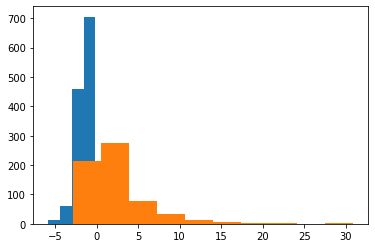

In [27]:
plt.hist(all_etis[all_etis['rank'] == False]['HB'])
plt.hist(all_etis[all_etis['rank']]['HB'])

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline


model = Pipeline([('imputer', KNNImputer()), ('clf', LogisticRegression(penalty='none'))])

In [29]:
model.fit(all_etis[['RC', 'HB', 'LN']], all_etis['rank'])

Pipeline(steps=[('imputer', KNNImputer()),
                ('clf', LogisticRegression(penalty='none'))])

In [30]:
prob = model.predict_proba(all_etis[['RC', 'HB', 'LN']])[:, -1]

In [31]:
all_etis['prob'] = prob

C:\Users\HP\AppData\Local\Temp\ipykernel_9464\608861208.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_etis['prob'] = prob


In [32]:
all_etis[all_etis['rank'] == False].sort_values(by='prob', ascending=False).head(50)

,RC,HB,LN,rank,prob
19804607,36.333194,NaN,NaN,False,0.999999
8880797,NaN,NaN,8.525745,False,0.999948
8111953,26.316703,3.914489,7.739924,False,0.999743
17699745,9.144241,8.369367,13.926472,False,0.999170
10764424,28.281436,3.415960,-1.849977,False,0.999061
17025134,17.569367,NaN,NaN,False,0.991445
16557619,17.319335,3.003885,1.312951,False,0.988252
8435430,13.076933,NaN,NaN,False,0.985482
15225195,14.903472,3.724845,0.276724,False,0.982142
3840946,14.722279,3.002021,2.468512,False,0.981029


In [33]:
model['clf'].coef_

array([[0.25889634, 0.51048145, 0.16166214]])

In [34]:
from sklearn.metrics import confusion_matrix


confusion_matrix(all_etis['rank'], model.predict(all_etis[['RC', 'HB', 'LN']]))

array([[5627,  118],
       [ 530,  440]], dtype=int64)

In [35]:
all_etis.loc[10879600]

RC      10.382906
HB       9.108495
LN       0.946755
rank         True
prob     0.996643
Name: 10879600, dtype: object

In [36]:
candidates = all_etis[(all_etis['rank'] == False) & (all_etis['prob'] > 0.5)].sort_values(by='prob', ascending=False)

In [37]:
candidates

,RC,HB,LN,rank,prob
19804607,36.333194,NaN,NaN,False,0.999999
8880797,NaN,NaN,8.525745,False,0.999948
8111953,26.316703,3.914489,7.739924,False,0.999743
17699745,9.144241,8.369367,13.926472,False,0.999170
10764424,28.281436,3.415960,-1.849977,False,0.999061
...,...,...,...,...,...
13717329,3.937558,NaN,NaN,False,0.505047
11196445,2.738926,NaN,NaN,False,0.504203
9048777,5.055404,1.139427,-0.472909,False,0.504164
11765280,4.273490,1.458144,NaN,False,0.502840


In [38]:
imputed_candidates = pd.DataFrame(model['imputer'].transform(candidates[['RC', 'HB', 'LN']]), index=candidates.index, columns=candidates.columns[:3])

In [39]:
imputed_candidates

,RC,HB,LN
19804607,36.333194,9.671084,6.164767
8880797,23.648096,8.152161,8.525745
8111953,26.316703,3.914489,7.739924
17699745,9.144241,8.369367,13.926472
10764424,28.281436,3.415960,-1.849977
...,...,...,...
13717329,3.937558,1.273844,0.914700
11196445,2.738926,1.445562,2.271137
9048777,5.055404,1.139427,-0.472909
11765280,4.273490,1.458144,-0.259862


(array([ 4., 18., 15.,  3.,  5.,  1.,  1.,  0.,  1.,  2.]),
 array([-2.51567091, -0.77168414,  0.97230263,  2.7162894 ,  4.46027617,
         6.20426294,  7.94824971,  9.69223648, 11.43622325, 13.18021002,
        14.92419679]),
 <BarContainer object of 10 artists>)

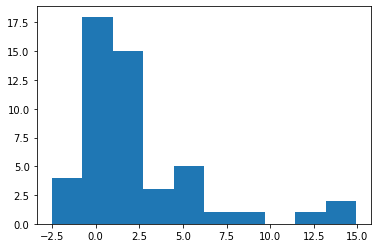

In [40]:
plt.hist(candidates['LN'])

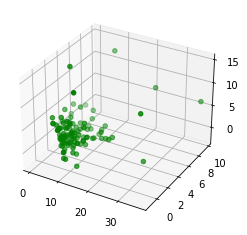

In [41]:
ax = plt.axes(projection='3d')

x0 = imputed_candidates['RC']
y0 = imputed_candidates['HB']
z0 = imputed_candidates['LN']

ax.scatter3D(x0, y0, z0, c='green')


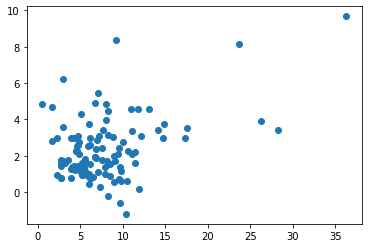

In [42]:
plt.scatter(x0, y0)

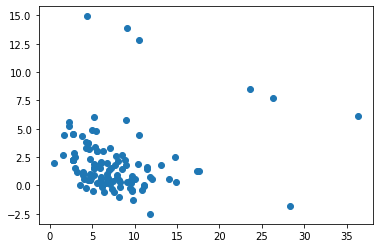

In [43]:
plt.scatter(x0, z0)

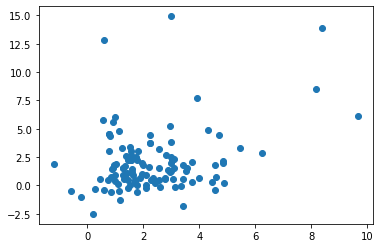

In [44]:
plt.scatter(y0, z0)

In [45]:
from sklearn.svm import OneClassSVM

anomaly = OneClassSVM(kernel='linear', gamma='scale').fit(imputed_candidates)

In [46]:
imputed_candidates['svm_pred'] = anomaly.predict(imputed_candidates)

In [47]:
imputed_candidates[imputed_candidates['svm_pred'] == 1]

,RC,HB,LN,svm_pred
19804607,36.333194,9.671084,6.164767,1
8880797,23.648096,8.152161,8.525745,1
8111953,26.316703,3.914489,7.739924,1
17699745,9.144241,8.369367,13.926472,1
10764424,28.281436,3.415960,-1.849977,1
17025134,17.569367,3.520711,1.262773,1
16557619,17.319335,3.003885,1.312951,1
8435430,13.076933,4.572940,1.825825,1
15225195,14.903472,3.724845,0.276724,1
3840946,14.722279,3.002021,2.468512,1


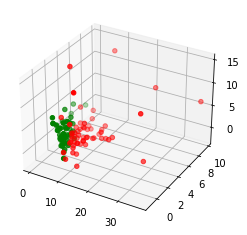

In [48]:
ax = plt.axes(projection='3d')

x0 = imputed_candidates[imputed_candidates['svm_pred'] == -1]['RC']
y0 = imputed_candidates[imputed_candidates['svm_pred'] == -1]['HB']
z0 = imputed_candidates[imputed_candidates['svm_pred'] == -1]['LN']

x1 = imputed_candidates[imputed_candidates['svm_pred'] == 1]['RC']
y1 = imputed_candidates[imputed_candidates['svm_pred'] == 1]['HB']
z1 = imputed_candidates[imputed_candidates['svm_pred'] == 1]['LN']

ax.scatter3D(x0, y0, z0, c='green')
ax.scatter3D(x1, y1, z1, c='red')


In [62]:
anomaly_lof = Pipeline([('scaler', MinMaxScaler()), ('lof', LocalOutlierFactor(metric=elastic_euclidean(1, 1, 0.7)))])

In [63]:
res = anomaly_lof.fit_predict(imputed_candidates[['RC', 'HB', 'LN']])

In [64]:
imputed_candidates['lof_pred'] = res

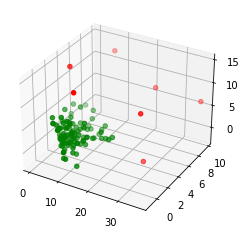

In [65]:
ax = plt.axes(projection='3d')

x0 = imputed_candidates[imputed_candidates['lof_pred'] == 1]['RC']
y0 = imputed_candidates[imputed_candidates['lof_pred'] == 1]['HB']
z0 = imputed_candidates[imputed_candidates['lof_pred'] == 1]['LN']

x1 = imputed_candidates[imputed_candidates['lof_pred'] == -1]['RC']
y1 = imputed_candidates[imputed_candidates['lof_pred'] == -1]['HB']
z1 = imputed_candidates[imputed_candidates['lof_pred'] == -1]['LN']

ax.scatter3D(x0, y0, z0, c='green')
ax.scatter3D(x1, y1, z1, c='red')

In [66]:
strong_skillbans = imputed_candidates[imputed_candidates['lof_pred'] == -1]

In [67]:
skillbans = candidates[candidates['prob'] > candidates.loc[strong_skillbans.index]['prob'].quantile(q=0.25)]

In [68]:
skillbans = skillbans.reset_index().rename({'index': 'user_id'}, axis=1).merge(player_id_name)[['user_id', 'username', 'RC', 'HB', 'LN', 'prob']]

In [69]:
skillbans

,user_id,username,RC,HB,LN,prob
0,19804607,Matthia,36.333194,NaN,NaN,0.999999
1,8880797,MyAngelKokomi,NaN,NaN,8.525745,0.999948
2,8111953,_Seth,26.316703,3.914489,7.739924,0.999743
3,17699745,MIkuaimbot,9.144241,8.369367,13.926472,0.999170
4,10764424,Mantozi,28.281436,3.415960,-1.849977,0.999061
5,17025134,Vaydex,17.569367,NaN,NaN,0.991445
6,16557619,Buffieman,17.319335,3.003885,1.312951,0.988252
7,8435430,_lyko,13.076933,NaN,NaN,0.985482
8,15225195,SPLONK,14.903472,3.724845,0.276724,0.982142


In [70]:
skillbans.to_csv('skillbans.csv', index=False)

In [71]:
weak_skillbans = candidates[candidates['prob'] > candidates.loc[strong_skillbans.index]['prob'].min()]

In [72]:
weak_skillbans = weak_skillbans.reset_index().rename({'index': 'user_id'}, axis=1).merge(player_id_name)[['user_id', 'username', 'RC', 'HB', 'LN', 'prob']]

In [73]:
weak_skillbans.tail(50)

,user_id,username,RC,HB,LN,prob
0,19804607,Matthia,36.333194,NaN,NaN,0.999999
1,8880797,MyAngelKokomi,NaN,NaN,8.525745,0.999948
2,8111953,_Seth,26.316703,3.914489,7.739924,0.999743
3,17699745,MIkuaimbot,9.144241,8.369367,13.926472,0.999170
4,10764424,Mantozi,28.281436,3.415960,-1.849977,0.999061
5,17025134,Vaydex,17.569367,NaN,NaN,0.991445
6,16557619,Buffieman,17.319335,3.003885,1.312951,0.988252
7,8435430,_lyko,13.076933,NaN,NaN,0.985482
8,15225195,SPLONK,14.903472,3.724845,0.276724,0.982142
9,3840946,SitekX,14.722279,3.002021,2.468512,0.981029


In [74]:
weak_skillbans.to_csv('weak_skillbans_ranked.csv', index=False)